In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours

import sys
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

### Detector

In [2]:
def detect(image_src, row_num, row_count, fig=None, save2file=False, save_dir=''):
    resized = imutils.resize(image_src, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction
    gradX = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
    gradY = cv2.Sobel(gray, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)

    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)
    
    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.1.jpg'), gradient)
    else:
        a = fig.add_subplot(row_count, 5, 5 * row_num + 1)
        plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB))
        a.set_title('Gradient')
    
    blurred = cv2.blur(gradient, (9, 9))
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.2.jpg'), thresh)
    else:
        a = fig.add_subplot(row_count, 5, 5 * row_num + 2)
        plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB))
        a.set_title('Thresholded')
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.3.jpg'), closed)
    else:
        a = fig.add_subplot(row_count, 5, 5 * row_num + 3)
        plt.imshow(cv2.cvtColor(closed, cv2.COLOR_GRAY2RGB))
        a.set_title('Morfology closed')
    
    morph = cv2.erode(closed, None, iterations = 6)
    morph = cv2.dilate(morph, None, iterations = 3)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.4.jpg'), morph)
    else:
        a = fig.add_subplot(row_count, 5, 5 * row_num + 4)
        plt.imshow(cv2.cvtColor(morph, cv2.COLOR_GRAY2RGB))
        a.set_title('Morfology erode-dilate')
    
    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    if len(cnts):
        c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(resized, (x, y), (x + w, y + h), (0, 255, 0), 2)

    if save2file:
        cv2.imwrite(os.path.join(save_dir, str(row_num).zfill(len(str(row_count))) + '.5.jpg'), resized)
    else:
        a = fig.add_subplot(row_count, 5, 5 * row_num + 5)
        plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
        a.set_title('Detected')
    
    return gradient, thresh, closed, morph, resized


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


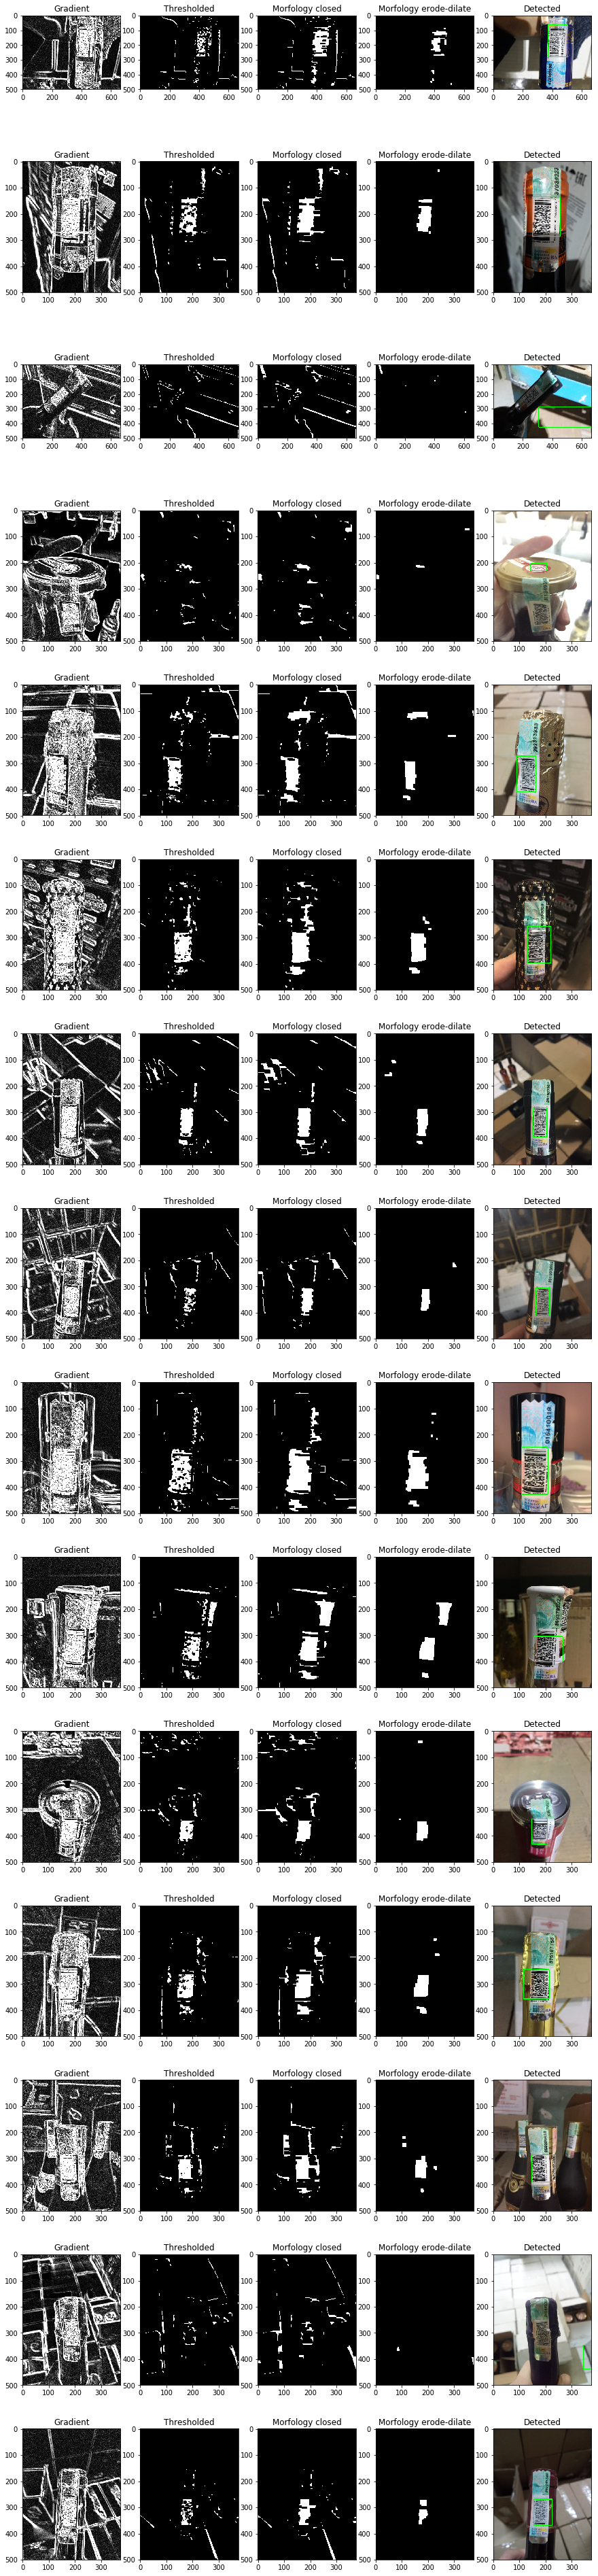

In [25]:
DIR = 'test_data'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0
fig = plt.figure(figsize=(15, 70))

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))
    detect(file_src, current_file_index, filescount, fig)
    current_file_index += 1
    
plt.show()

In [3]:
DIR = 'data/Respect_wholesale'
OUTPUT_DIR = 'data/Respect_wholesale/barcode_detect'
filescount = len([name for name in os.listdir(DIR) if (name.endswith(".JPG") or name.endswith(".jpg"))])
current_file_index = 0

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for filename in tqdm(os.listdir(DIR)):
    if not (filename.endswith(".JPG") or filename.endswith(".jpg")):
        continue
        
    file_src = cv2.imread(os.path.join(DIR, filename))
    detect(file_src, current_file_index, filescount, fig=None, save2file=True, save_dir=OUTPUT_DIR)
    current_file_index += 1

100%|██████████| 385/385 [02:16<00:00,  2.08it/s]
